# Artificial Sample Task - Geometries


## Generating Samples

In [270]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Circle

# Generate data
def generate_data(n_samples : int, error_coef : float, **kwargs):
    """Generates n_sample rows of artificial data for training. THe 'wrongness' (amount of 
    differences) of each negative sample is controlled by error_coef, which is currently the
    percentage of errors w.r.t. to sequence length.
    
    Returns: 
        X (ndarray of int): 3-d ndarray of shape (n_samples, max_len (default 20), 2). Each entry has
        two integers, one representing shape and the other representing size. Sequence length of
        each entry is uniformly distributed between min_len and max_len (default 2 and 20). Empty
        space padded with 0s.
        y (ndarray of int): 1-d array of shape (n_samples). Positive (rule-following) samples correspond
        to 1 and negative to 0.

    Args:
        n_samples (int): number of samples
        error_coef (float): the coefficient that controls how 'wrong' a negative sample is. Currently
        probability of the geometric distribution controlling mistakes. E.g. samples error_coef of 0.2 
        will, on average, have 5 incorrect entries.
    """
    
    # Initialize & unpack parameters
    n_shapes, n_colors, min_len, max_len, failure_rate= 5, 2, 2, 20, 0.5
    return_indices = False
    
    if "n_shapes" in kwargs:
        n_shapes = kwargs["n_shapes"]
    if "n_colors" in kwargs:
        n_colors = kwargs["n_colors"]
    if "min_len" in kwargs:
        min_len = kwargs["min_len"]
    if "max_len" in kwargs:
        max_len = kwargs["max_len"]
    if "failure_rate" in kwargs:
        failure_rate = kwargs["failure_rate"]
    if "return_indices" in kwargs:
        return_indices = kwargs["return_indices"]
    
    # Cast type
    n_samples = int(n_samples)
        
    # Initialize return data 
    y = np.random.binomial(1, failure_rate, size=n_samples)
    X = np.zeros(shape=(n_samples, max_len, 2), dtype=int)
    # Sequence length of each sample
    sample_len = np.random.randint(low=min_len, high=max_len + 1, size=n_samples)

    # Following "minimal rule breaking", first generate all as positive samples
    for i, n_variants in enumerate([n_shapes, n_colors]):
        for j in range(max_len):
            if j == 0:
                # add one because 0 is reserved for padding
                sample_column = np.random.randint(n_variants, size=n_samples) + 1 
            else:
                # only generates n-1 possible shapes because shapes cannot be repeated
                sample_column = np.random.randint(n_variants - 1, size=n_samples) + 1
                # if current sample is larger than original sample, add one
                # this makes the range of generated shape 1 to n as opposed to 1 to n-1
                sample_column[sample_column >= X[:, j - 1, i]] += 1
                # throw away if already longer than desired seq length
                sample_column[sample_len <= j] = 0

            X[:, j, i] = sample_column
    
    # Row # of y=0 samples
    negative_sample_rows = np.argwhere(y == 0)
    n_negative_samples = negative_sample_rows.size
    # Seq length of y=0 samples
    negative_sample_len = sample_len[negative_sample_rows].flatten()
    # Array storing number of mistakes each negative sample; constrained to be under sequence length
    n_perturbations = np.minimum(negative_sample_len, np.random.geometric(error_coef, size=n_negative_samples))

    #n_perturbations = np.repeat(1, n_negative_samples)
    assert np.min(n_perturbations) >= 1
    
    # Initialize array storing indices that needs to be perturbed
    # rows -> the n-th sample; indices -> the n-th element in sequence; part -> shape / color
    perturbed_rows = np.repeat(negative_sample_rows, n_perturbations)
    perturbed_indices = np.zeros(np.sum(n_perturbations), dtype=int)
    perturbed_part = np.random.binomial(1, 0.5, size=perturbed_indices.size)
    index_generator = np.random.default_rng() 
    # Generate indices to perturb
    start_index= 0
    for i in range(n_negative_samples):
        perturbed_indices[start_index: start_index + n_perturbations[i]] = \
            index_generator.choice(negative_sample_len[i], size=n_perturbations[i], replace=False)
        start_index += n_perturbations[i]
        
    # San check: # of swapped indices equal total number that should be swapped
    assert start_index == np.sum(n_perturbations)
    
    # Now perturb some samples to make them not rule following
    # replace each generated data with its previous sample, so the sequence becomes repeating
    # for the first sample replace it with the next
    replace_indices = perturbed_indices.copy()
    replace_indices -= 1
    replace_indices[replace_indices == -1] = 1
    
    # TODO: this test does not always pass. there's probably a major bug w perturbations / seq length
    # San check: every replacement happens at meaninful indices
    #assert np.any(X[perturbed_rows, perturbed_indices, perturbed_part] == 0) is False
    
    # Replace
    X[perturbed_rows, perturbed_indices, perturbed_part] = X[perturbed_rows, replace_indices, perturbed_part]
    
    if return_indices:
        return (X, y, (perturbed_rows, perturbed_indices, perturbed_part))
    else:
        return (X, y)

def visualize(X, y, **kwargs):
    """Visualize 10 samples (5 positive, 5 negative) chosen from given X and y
    with matplotlib

    Args:
        X (ndarray): 3D integer array of generated data 
        y (ndarray): 1D integer array of 0s and 1s, the tag of X
    """
    
    seq_len = X.shape[1] 
    n_samples = 5
    colors = ['white', 'black', 'red', 'blue', 'green', 'yellow']
    
    ax = plt.axes()

    ax.set_xlim(-0.5, seq_len - 0.5 + 3)
    ax.set_xticks(np.arange(seq_len))
    ax.set_xlabel('sequence index')
    ax.set_ylim(-0.5, n_samples * 2 - 0.25)
    ax.set_yticks(np.arange(n_samples * 2))
    ax.set_ylabel('# of sample')
    ax.set_aspect('equal')
    ax.set_facecolor('silver')
    
    index_generator = np.random.default_rng() 
    
    positive_indices = index_generator.choice(np.argwhere(y == 1), n_samples)
    negative_indices = index_generator.choice(np.argwhere(y == 0), n_samples)
    
    for i in range(n_samples):
        for j in range(seq_len):
            if X[positive_indices[i], j, 0] != 0:
                # Display positive samples
                ax.add_patch(RegularPolygon((j, i), radius=0.4, numVertices=X[positive_indices[i], j, 0].item() + 2, 
                                            facecolor= colors[int(X[positive_indices[i], j, 1].item()) - 1],))
                # Display negative samples
                ax.add_patch(RegularPolygon((j, i + n_samples), radius=0.4, numVertices=X[negative_indices[i], j, 0].item() + 2, 
                                            facecolor= colors[int(X[negative_indices[i], j, 1].item()) - 1],))
        
        # Display tag 
        ax.annotate(f"y = {y[positive_indices[i]].item()}", (j + 1, i))
        ax.annotate(f"y = {y[negative_indices[i]].item()}",(j + 1, i + n_samples))
    
    if "indices" in kwargs:
        indices = kwargs["indices"]
        row, column, part = indices
        # Display position of swaps
        for i in range(n_samples):
            print(f"swapped: {column[row == negative_indices[i]]} on part {part[row == negative_indices[i]]} for sample on row # {i + n_samples}")
            

In [279]:
X, y, perturbed_indices = generate_data(1e6, 0.3, return_indices=True)

swapped: [0 1] on part [1 0] for sample on row # 5
swapped: [0 1 2] on part [1 1 0] for sample on row # 6
swapped: [2 0 7] on part [0 0 1] for sample on row # 7
swapped: [ 1  8 12  6 11  7  3  9 13  0 14  2] on part [0 0 1 1 1 1 1 1 1 0 0 1] for sample on row # 8
swapped: [2] on part [0] for sample on row # 9


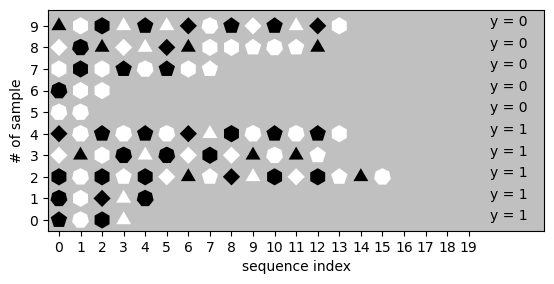

In [272]:
visualize(X, y, indices=perturbed_indices)

## Create Dataloader

In [295]:
import torch
from torch.utils.data import Dataset, DataLoader

max_seq_len = 20
hidden_size = 32
batch_size = 32
sample_len = 1e5

X, y = generate_data(sample_len, 0.3, max_len=max_seq_len)

# Define dataloader and load data
class Geometries(Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y)
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

X_train, y_train, X_test, y_test = X[int(sample_len / 10):], y[int(sample_len / 10):], X[:int(sample_len / 10)], y[:int(sample_len / 10)]
training_data = Geometries(X_train, y_train)
test_data = Geometries(X_test, y_test)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)    

## Create Model

In [ ]:
from torch import nn
from transformers import BertConfig, BertModel

config = BertConfig(vocab_size= 16, hidden_size = hidden_size, num_hidden_layers= 4, 
                    num_attention_heads= 4, intermediate_size= 64, 
                    max_position_embeddings= max_seq_len)
bert_encoder = BertModel(config)

class Geometries_Tokenizer():
    def __init__(self):
        pass
    
    def __call__(self, x : list):
        pass

class Classifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.tokenizer = Geometries()
        self.bert = bert_encoder
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(nn.Linear(max_seq_len * hidden_size, 2), 
                                            nn.Softmax())      
        
    def foward(self, x):
        x = self.tokenizer(x)
        x = self.bert(x)
        logits = self.classifier(x)
        
        return logits


In [275]:
print(model.out)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(16, 32, padding_idx=0)
    (position_embeddings): Embedding(20, 32)
    (token_type_embeddings): Embedding(2, 32)
    (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=32, out_features=32, bias=True)
            (key): Linear(in_features=32, out_features=32, bias=True)
            (value): Linear(in_features=32, out_features=32, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=32, out_features=32, bias=True)
            (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
     